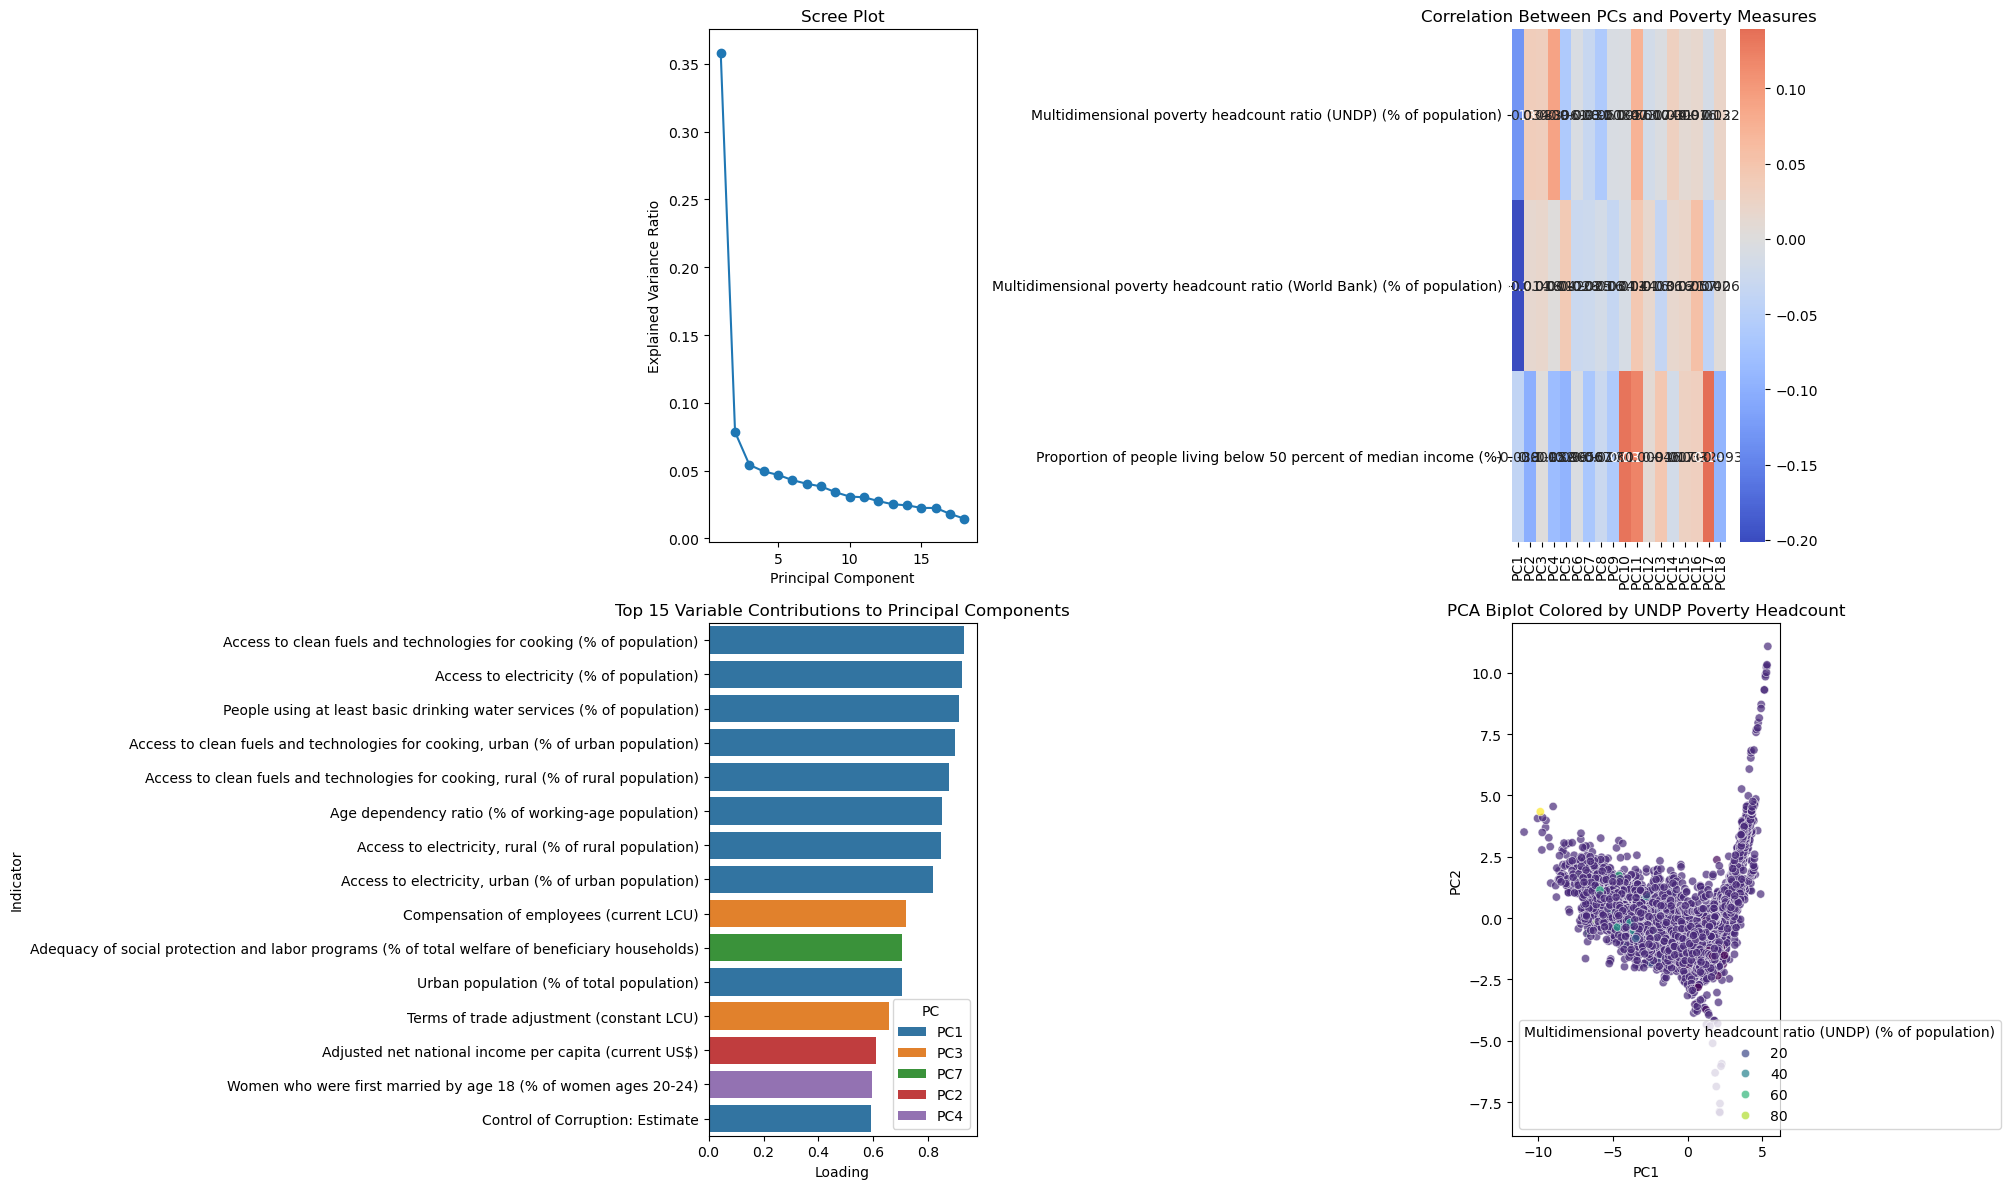

Explained Variance Ratios: [0.35824031 0.07846784 0.05427445 0.04946317 0.04689399 0.04304233
 0.04033449 0.03840752 0.03411762 0.03088351 0.03040074 0.02754569
 0.02522447 0.02444394 0.02252621 0.02250564 0.01810401 0.01458578]
Cumulative Variance: [0.35824031 0.43670815 0.49098259 0.54044576 0.58733976 0.63038209
 0.67071657 0.70912409 0.74324171 0.77412522 0.80452596 0.83207165
 0.85729612 0.88174006 0.90426626 0.9267719  0.94487591 0.95946169]


In [50]:
# PCA on original dataset
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('sap.csv', dtype={"Topic": str}, low_memory=False)
year_columns = [col for col in df.columns if col.isdigit()]

df_long = df.melt(
    id_vars=["Country Name", "Indicator Name", "Topic", "Indicator Code"],
    value_vars=year_columns,
    var_name="Year",
    value_name="Value"
)
df_long["Year"] = df_long["Year"].astype(int)

df_pivot = df_long.pivot_table(
    index=["Country Name", "Year"],
    columns="Indicator Name",
    values="Value"
).reset_index()

target_indicators = [
    "Control of Corruption: Estimate",
    "Compensation of employees (current LCU)",
    "Compensation of employees (% of expense)",
    "Political Stability and Absence of Violence/Terrorism: Estimate",
    "Multilateral debt service (% of public and publicly guaranteed debt service)",
    "Adjusted savings: education expenditure (current US$)",
    "Adjusted net national income per capita (current US$)",
    "Terms of trade adjustment (constant LCU)",
    "Access to clean fuels and technologies for cooking, rural (% of rural population)",
    "Access to clean fuels and technologies for cooking, urban (% of urban population)",
    "Access to clean fuels and technologies for cooking (% of population)",
    "Access to electricity, rural (% of rural population)",
    "Access to electricity, urban (% of urban population)",
    "Access to electricity (% of population)",
    "Urban population (% of total population)",
    "Adequacy of social protection and labor programs (% of total welfare of beneficiary households)",
    "Unemployment, total (% of total labor force) (national estimate)",
    "Literacy rate, adult total (% of people ages 15 and above)",
    "School enrollment, primary (gross), gender parity index (GPI)",
    "Children out of school (% of primary school age)",
    "People using at least basic drinking water services (% of population)",
    "Current health expenditure (% of GDP)",
    "Births attended by skilled health staff (% of total)",
    "Age dependency ratio (% of working-age population)",
    "Women who were first married by age 18 (% of women ages 20-24)"
]

# we're not including the 3 poverty measures....maybe the third one shouldn't be here tho
poverty_measures = [
    "Multidimensional poverty headcount ratio (UNDP) (% of population)",
    "Multidimensional poverty headcount ratio (World Bank) (% of population)",
    "Proportion of people living below 50 percent of median income (%)"
]

analysis_df = df_pivot[["Country Name", "Year"] + poverty_measures + target_indicators].copy()

for col in poverty_measures + target_indicators:
    analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')

imputer = SimpleImputer(strategy='median')
analysis_df[target_indicators] = imputer.fit_transform(analysis_df[target_indicators])
analysis_df[poverty_measures] = imputer.fit_transform(analysis_df[poverty_measures])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(analysis_df[target_indicators])

pca = PCA(n_components=0.95)
principal_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(principal_components, 
                     columns=[f'PC{i+1}' for i in range(pca.n_components_)])

full_df = pd.concat([analysis_df.reset_index(drop=True), pca_df], axis=1)

corr_matrix = full_df[poverty_measures + list(pca_df.columns)].corr()

plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         pca.explained_variance_ratio_, 'o-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

plt.subplot(2, 2, 2)
sns.heatmap(corr_matrix.loc[poverty_measures, pca_df.columns], 
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between PCs and Poverty Measures')

loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_),
                       columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                       index=target_indicators)

plt.subplot(2, 2, 3)
top_loadings = loadings.abs().stack().nlargest(15).reset_index()
top_loadings.columns = ['Indicator', 'PC', 'Loading']
sns.barplot(x='Loading', y='Indicator', hue='PC', data=top_loadings)
plt.title('Top 15 Variable Contributions to Principal Components')

plt.subplot(2, 2, 4)
sns.scatterplot(x='PC1', y='PC2', data=full_df, 
                hue='Multidimensional poverty headcount ratio (UNDP) (% of population)', 
                palette='viridis', alpha=0.7)
plt.title('PCA Biplot Colored by UNDP Poverty Headcount')
plt.tight_layout()
plt.show()

print("Explained Variance Ratios:", pca.explained_variance_ratio_)
print("Cumulative Variance:", np.cumsum(pca.explained_variance_ratio_))

In [52]:
pc_mpi = ["PC1", "PC2", "PC5", "PC3", "PC4"]
mpi_equation = loadings[pc_mpi].sum(axis=1)
print(mpi_equation.sort_values(ascending=False))

Control of Corruption: Estimate                                                                    1.527660
Political Stability and Absence of Violence/Terrorism: Estimate                                    1.355163
Adjusted net national income per capita (current US$)                                              1.278018
Access to clean fuels and technologies for cooking, rural (% of rural population)                  0.938120
Access to clean fuels and technologies for cooking (% of population)                               0.842111
People using at least basic drinking water services (% of population)                              0.810633
Urban population (% of total population)                                                           0.791419
Compensation of employees (current LCU)                                                            0.788759
Access to clean fuels and technologies for cooking, urban (% of urban population)                  0.712831
Access to electricity (% of 

In [54]:
import pandas as pd

df = pd.read_csv('sap.csv')

# Removing unneeded columns
df.drop(columns=['Country Code', "short description","long description","Unit of measure", "Topic", "Indicator Code"], inplace=True)
# For MPI, turning all rows with no data into 0
year_columns = [col for col in df.columns if col.isdigit()]
mpi_undp = 'Multidimensional poverty headcount ratio (UNDP) (% of population)'
mpi_wb = 'Multidimensional poverty headcount ratio (World Bank) (% of population)'
mask = (df["Indicator Name"] == mpi_undp) & df[year_columns].isna().all(axis=1)
df.loc[mask, year_columns] = 0
mask = (df["Indicator Name"] == mpi_wb) & df[year_columns].isna().all(axis=1)
df.loc[mask, year_columns] = 0
# Dropping (Country, indicator) pairs with no data for all years
df = df.dropna(subset=year_columns, how='all')
# Backfilling year rows
df[year_columns] = df[year_columns].ffill(axis=1)
df[year_columns] = df[year_columns].bfill(axis=1)

df.to_csv("cleaned_dataset.csv", index=False)
# print(df.loc[mpi_undp].isnull().sum())


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26920\785801763.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('sap.csv')


In [56]:
# Select relevant columns
value_columns = df.columns[2:]  # Assuming the first 2 columns are metadata, and the rest are years
df_filtered = df[['Country Name', 'Indicator Name'] + list(value_columns)]
# df_filtered.head(10)

# Convert to long format (unpivot years)
df_long = df.melt(id_vars=["Country Name", "Indicator Name"], 
                  value_vars=year_columns, 
                  var_name="Year", 
                  value_name="Value")
# df_long.head(10)

# Convert Year to integer
df_long["Year"] = df_long["Year"].astype(int)

# Pivot table to align indicators as columns
df_pivot = df_long.pivot_table(index=["Country Name", "Year"], 
                               columns="Indicator Name", 
                               values="Value").reset_index()

df_pivot['Country Name'] = df_pivot['Country Name'].astype(str) + '_' + df_pivot['Year'].astype(str)
df_pivot.drop(columns="Year", inplace=True)

# Split 'Country_Year' into separate 'Country' and 'Year' columns
df_pivot[['Country', 'Year']] = df_pivot['Country Name'].str.split('_', expand=True)

# Convert 'Year' to integer for correct sorting
df_pivot['Year'] = df_pivot['Year'].astype(int)

# Sort by Country and Year to ensure proper time-series order
df_pivot.sort_values(by=['Country', 'Year'], inplace=True)

df_pivot['Country_Year'] = df_pivot['Country'] + '_' + df_pivot['Year'].astype(str)

# # Drop the separate 'Country' and 'Year' columns (optional)
df_pivot.drop(columns=['Country', 'Year'], inplace=True)

# # Save the cleaned dataset
df_pivot.to_csv('cleaned_dataset.csv', index=False)

print(df_pivot[mpi_undp].sum())

# print("Missing values handled using Forward & Backward Fill.")

61761.6


In [58]:
# benchmarking using HDI 

df1 = pd.read_csv('hdr_general.csv', encoding='ISO-8859-1')

# Keep only the desired columns
df1 = df1[['country', 'hdi', 'year']]

# Merge 'country' and 'year' into a new column
df1['Country_Year'] = df1['country'].astype(str) + '_' + df1['year'].astype(str)

# Drop the original 'country' and 'year' columns if not needed
df1 = df1[['Country_Year', 'hdi']]

df2 = pd.read_csv('cleaned_dataset.csv', encoding='ISO-8859-1')  # Contains Country_year (2000-2023)

# Filter df1 to keep only HDI values from 2000 to 2022
df1['year'] = df1['Country_Year'].str.split('_').str[1].astype(int)  # Extract the year
df1 = df1[(df1['year'] >= 2000) & (df1['year'] <= 2022)]  # Keep only 2000-2022

# Drop the extracted 'year' column as it's no longer needed
df1 = df1[['Country_Year', 'hdi']]

# Merge df1 into df2 based on 'Country_year'
df2 = df2.merge(df1, on='Country_Year', how='left')

# Save the updated dataset (optional)
df2.to_csv('cleaned_with_hdi.csv', index=False)

[0]	validation_0-rmse:0.73399	validation_1-rmse:0.73080
[1]	validation_0-rmse:0.54611	validation_1-rmse:0.54937
[2]	validation_0-rmse:0.41623	validation_1-rmse:0.42791
[3]	validation_0-rmse:0.32326	validation_1-rmse:0.34762
[4]	validation_0-rmse:0.25752	validation_1-rmse:0.29339
[5]	validation_0-rmse:0.21431	validation_1-rmse:0.25113
[6]	validation_0-rmse:0.17762	validation_1-rmse:0.21900
[7]	validation_0-rmse:0.15697	validation_1-rmse:0.20090
[8]	validation_0-rmse:0.14373	validation_1-rmse:0.19154
[9]	validation_0-rmse:0.12748	validation_1-rmse:0.17946
[10]	validation_0-rmse:0.11738	validation_1-rmse:0.17250
[11]	validation_0-rmse:0.11135	validation_1-rmse:0.16966
[12]	validation_0-rmse:0.10580	validation_1-rmse:0.16504
[13]	validation_0-rmse:0.10126	validation_1-rmse:0.16246
[14]	validation_0-rmse:0.09484	validation_1-rmse:0.15824
[15]	validation_0-rmse:0.09215	validation_1-rmse:0.15576
[16]	validation_0-rmse:0.08826	validation_1-rmse:0.15456
[17]	validation_0-rmse:0.08284	validation

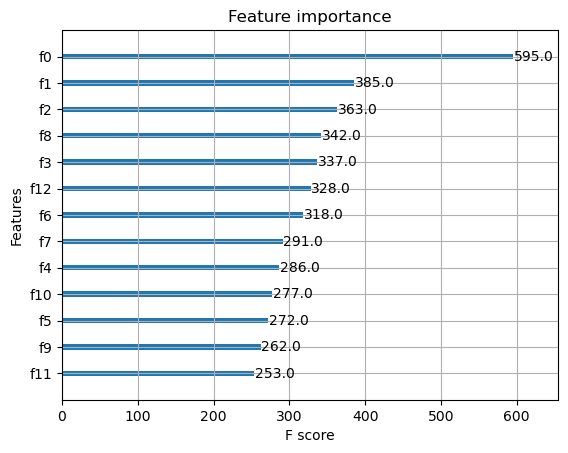


Predictions (Y_pred_scaled):
[ 1.2514926  -0.48260957 -0.48954266 ...  1.3741059  -0.48163953
 -0.48260957]
Number of predictions: 1277

Actual test values (Y_test_scaled):
[ 1.38731461 -0.4870295  -0.4870295  ...  1.39736471 -0.4870295
 -0.4870295 ]
Number of test values: 1277

Final Model Performance:
Mean Squared Error: 0.013201913114978864
Root Mean Squared Error (RMSE): 0.11489957839339039
Mean Absolute Error (MAE): 0.03839391187208616


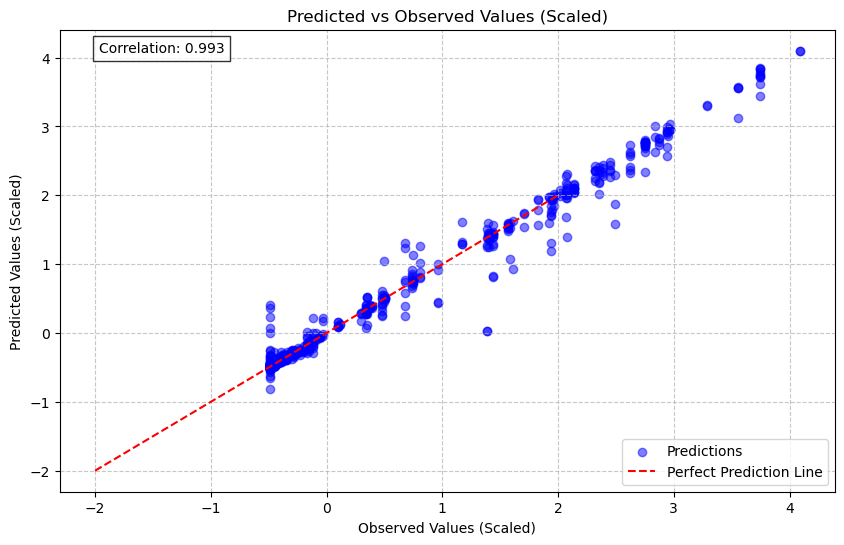

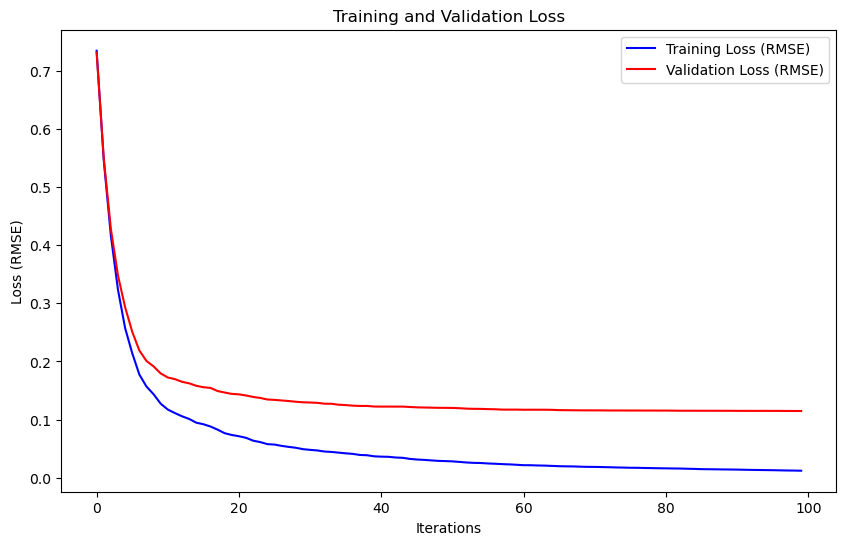

In [60]:
# XG boost with 80% training, 20% testing


# Import necessary libraries
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import linregress
df = pd.read_csv("cleaned_with_hdi.csv")
# Define the feature columns and target variable
X_columns = [
    "Control of Corruption: Estimate", 
    "Political Stability and Absence of Violence/Terrorism: Estimate", 
    "Adjusted net national income per capita (current US$)", 
    "Access to clean fuels and technologies for cooking, rural (% of rural population)",  
    "People using at least basic drinking water services (% of population)", 
    "Urban population (% of total population)", "Compensation of employees (current LCU)", 
    "Access to electricity (% of population)", "Terms of trade adjustment (constant LCU)", 
    "Adjusted savings: education expenditure (current US$)", 
    "School enrollment, primary (gross), gender parity index (GPI)", 
    "Current health expenditure (% of GDP)", 
    "Women who were first married by age 18 (% of women ages 20-24)"
]
Y_column = 'Multidimensional poverty headcount ratio (UNDP) (% of population)'

# Multidimensional poverty headcount ratio (World Bank) (% of population)

# Prepare X (features) and Y (target)
X = df[X_columns]
Y = df[Y_column]

# Step 1: Split the data into training and test sets (85-15 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Step 2: Scale the features and target variable using StandardScaler
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1, 1))
Y_test_scaled = scaler_Y.transform(Y_test.values.reshape(-1, 1))

# Ensure Y_train_scaled is a 1D array for XGBoost
Y_train_scaled = Y_train_scaled.ravel()
Y_test_scaled = Y_test_scaled.ravel()

# Step 3: Initialize and train the XGBoost regressor model
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Define evaluation sets (training and validation data)
eval_set = [(X_train_scaled, Y_train_scaled), (X_test_scaled, Y_test_scaled)]

# Train the model with evaluation monitoring
model.fit(X_train_scaled, Y_train_scaled, eval_set=eval_set, verbose=True)

# Step 4: Make predictions on the test set
Y_pred_scaled = model.predict(X_test_scaled)

# Step 5: Evaluate the model using Mean Squared Error (MSE), RMSE, and MAE
mse = mean_squared_error(Y_test_scaled, Y_pred_scaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test_scaled, Y_pred_scaled)



# Step 6: Plot feature importance (Optional)
xgb.plot_importance(model)
plt.show()

# Step 7: Ensure Y_test and Y_pred_scaled are 1D arrays for plotting
Y_test_flat = Y_test.values.reshape(-1, 1).ravel()  # Flatten Y_test to 1D
Y_pred_flat = Y_pred_scaled.ravel()  # Flatten predictions to 1D

# Print predictions and test values with their lengths
print("\nPredictions (Y_pred_scaled):")
print(Y_pred_scaled)
print(f"Number of predictions: {len(Y_pred_scaled)}")

print("\nActual test values (Y_test_scaled):")
print(Y_test_scaled)
print(f"Number of test values: {len(Y_test_scaled)}")


# Print evaluation metrics
print('\nFinal Model Performance:')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')


# Plot scaled predicted vs observed values
plt.figure(figsize=(10, 6))
plt.scatter(Y_test_scaled, Y_pred_scaled, color='blue', alpha=0.5, label='Predictions')
plt.plot([-2, 2], [-2, 2], 'r--', label='Perfect Prediction Line')  # Reference line
plt.xlabel("Observed Values (Scaled)")
plt.ylabel("Predicted Values (Scaled)")
plt.title("Predicted vs Observed Values (Scaled)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add correlation coefficient
correlation = np.corrcoef(Y_test_scaled, Y_pred_scaled)[0,1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# Step 10: Plot the Training and Validation Loss
eval_results = model.evals_result()
train_rmse = eval_results['validation_0']['rmse']
val_rmse = eval_results['validation_1']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_rmse)), train_rmse, label='Training Loss (RMSE)', color='blue')
plt.plot(range(len(val_rmse)), val_rmse, label='Validation Loss (RMSE)', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss (RMSE)')
plt.legend()
plt.show()


In [62]:
df = pd.read_csv("cleaned_with_hdi.csv")

[0]	validation_0-rmse:0.72895	validation_1-rmse:0.70561
[1]	validation_0-rmse:0.54196	validation_1-rmse:0.53833
[2]	validation_0-rmse:0.40673	validation_1-rmse:0.42188
[3]	validation_0-rmse:0.31300	validation_1-rmse:0.34074
[4]	validation_0-rmse:0.25243	validation_1-rmse:0.29182
[5]	validation_0-rmse:0.20331	validation_1-rmse:0.25235
[6]	validation_0-rmse:0.17522	validation_1-rmse:0.23586
[7]	validation_0-rmse:0.14715	validation_1-rmse:0.21329
[8]	validation_0-rmse:0.12913	validation_1-rmse:0.20153
[9]	validation_0-rmse:0.11601	validation_1-rmse:0.19309
[10]	validation_0-rmse:0.10769	validation_1-rmse:0.18755
[11]	validation_0-rmse:0.10071	validation_1-rmse:0.17808
[12]	validation_0-rmse:0.09126	validation_1-rmse:0.17187
[13]	validation_0-rmse:0.08343	validation_1-rmse:0.16618
[14]	validation_0-rmse:0.07965	validation_1-rmse:0.16289
[15]	validation_0-rmse:0.07545	validation_1-rmse:0.16069
[16]	validation_0-rmse:0.07328	validation_1-rmse:0.15922
[17]	validation_0-rmse:0.07012	validation

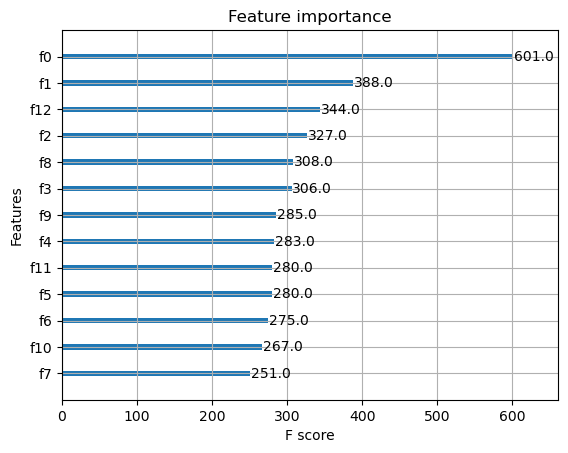


Final Model Performance:
Mean Squared Error: 0.016183789640876658
Root Mean Squared Error (RMSE): 0.12721552437056044
Mean Absolute Error (MAE): 0.04056213999157112


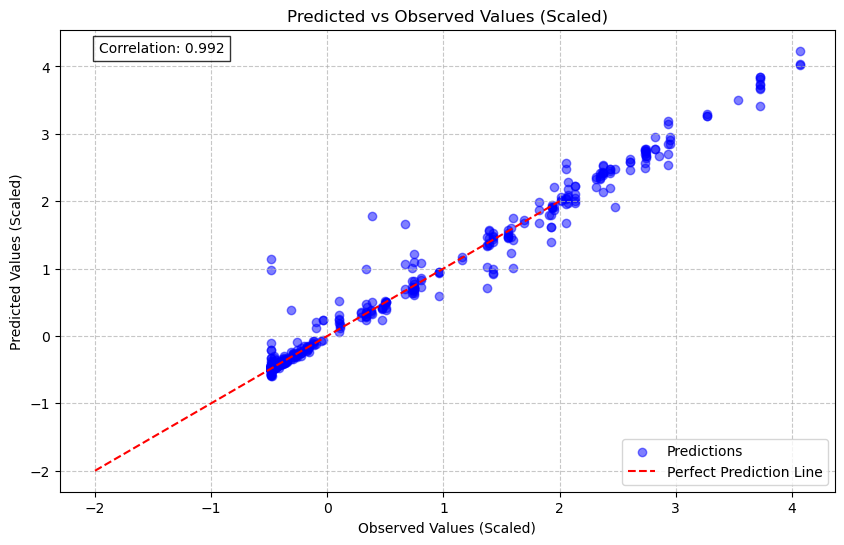

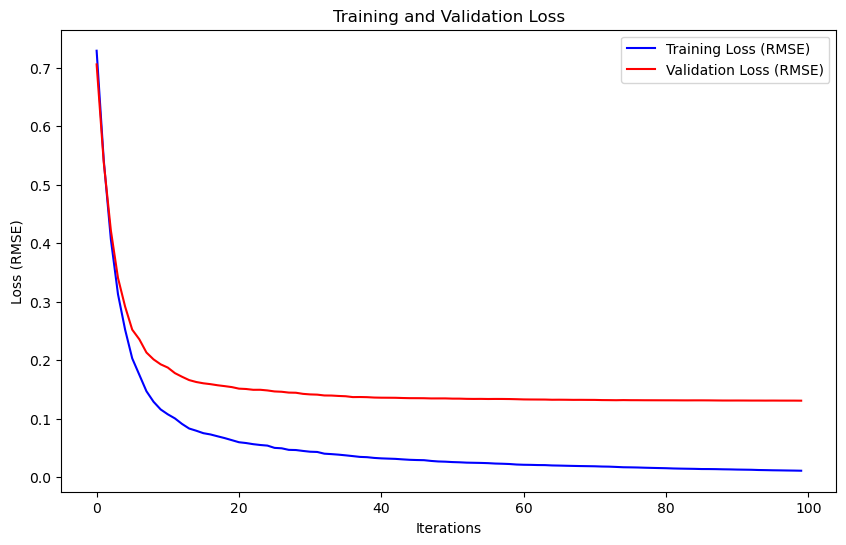

                    Country_Year  MPI_Rank  HDI_Rank
2741                   Iraq_2005       1.0     410.5
1634            El Salvador_2002       3.0     383.0
1632            El Salvador_2000       3.0     392.0
1650            El Salvador_2018       3.0     341.5
4962  Sao Tome and Principe_2018       7.5     394.0
...                          ...       ...       ...
1041                   Chad_2009     565.0     556.5
1049                   Chad_2017     565.0     547.0
4248                  Niger_2000     570.0     571.0
4258                  Niger_2010     570.0     561.0
4252                  Niger_2004     570.0     570.0

[571 rows x 3 columns]


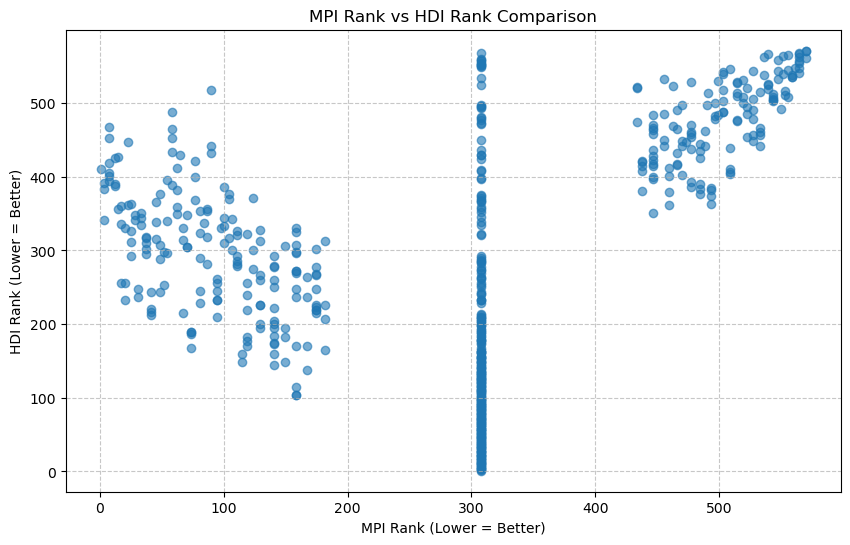

In [68]:
# XG boost with 70% training, 15% testing and 15% validating and benchmarking


# Import necessary libraries
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("cleaned_with_hdi.csv")

# Define the feature columns and target variable
X_columns = [
    "Control of Corruption: Estimate", 
    "Political Stability and Absence of Violence/Terrorism: Estimate", 
    "Adjusted net national income per capita (current US$)", 
    "Access to clean fuels and technologies for cooking, rural (% of rural population)",  
    "People using at least basic drinking water services (% of population)", 
    "Urban population (% of total population)", "Compensation of employees (current LCU)", 
    "Access to electricity (% of population)", "Terms of trade adjustment (constant LCU)", 
    "Adjusted savings: education expenditure (current US$)", 
    "School enrollment, primary (gross), gender parity index (GPI)", 
    "Current health expenditure (% of GDP)", 
    "Women who were first married by age 18 (% of women ages 20-24)"
]
Y_column = 'Multidimensional poverty headcount ratio (UNDP) (% of population)'

# Multidimensional poverty headcount ratio (World Bank) (% of population)

# Prepare X (features) and Y (target)
X = df[X_columns]
Y = df[Y_column]

# Step 1: Split the data into training (70%), validation (15%), and test (15%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.30, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.50, random_state=42)

# Step 2: Scale the features and target variable using StandardScaler
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1, 1)).ravel()
Y_val_scaled = scaler_Y.transform(Y_val.values.reshape(-1, 1)).ravel()
Y_test_scaled = scaler_Y.transform(Y_test.values.reshape(-1, 1)).ravel()

# Step 3: Initialize and train the XGBoost regressor model
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Define evaluation sets (training and validation data)
eval_set = [(X_train_scaled, Y_train_scaled), (X_val_scaled, Y_val_scaled)]

# Train the model with evaluation monitoring
model.fit(X_train_scaled, Y_train_scaled, eval_set=eval_set, verbose=True)

# Step 4: Make predictions on the test set
Y_pred_scaled = model.predict(X_test_scaled)

# Step 5: Evaluate the model using Mean Squared Error (MSE), RMSE, and MAE
mse = mean_squared_error(Y_test_scaled, Y_pred_scaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test_scaled, Y_pred_scaled)

# Step 6: Plot feature importance (Optional)
xgb.plot_importance(model)
plt.show()

# Ensure Y_test and Y_pred_scaled are 1D arrays for plotting
Y_test_flat = Y_test.values.reshape(-1, 1).ravel()  # Flatten Y_test to 1D
Y_pred_flat = Y_pred_scaled.ravel()  # Flatten predictions to 1D

# Print evaluation metrics
print('\nFinal Model Performance:')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Plot scaled predicted vs observed values
plt.figure(figsize=(10, 6))
plt.scatter(Y_test_scaled, Y_pred_scaled, color='blue', alpha=0.5, label='Predictions')
plt.plot([-2, 2], [-2, 2], 'r--', label='Perfect Prediction Line')  # Reference line
plt.xlabel("Observed Values (Scaled)")
plt.ylabel("Predicted Values (Scaled)")
plt.title("Predicted vs Observed Values (Scaled)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add correlation coefficient
correlation = np.corrcoef(Y_test_scaled, Y_pred_scaled)[0,1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# Step 7: Plot the Training and Validation Loss
eval_results = model.evals_result()
train_rmse = eval_results['validation_0']['rmse']
val_rmse = eval_results['validation_1']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_rmse)), train_rmse, label='Training Loss (RMSE)', color='blue')
plt.plot(range(len(val_rmse)), val_rmse, label='Validation Loss (RMSE)', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss (RMSE)')
plt.legend()
plt.show()

# -------------------------------
# Step 8: Benchmarking MPI vs. HDI Rankings
# -------------------------------

# Convert predictions and actual values to Pandas Series with original indices
Y_pred_series = pd.Series(np.abs(Y_pred_scaled), index=X_test.index, name="Predicted_MPI")
Y_test_series = pd.Series(np.abs(Y_test_scaled), index=X_test.index, name="Actual_MPI")

# Extract Country_Year and HDI for the test set
benchmark_df = df.loc[X_test.index, ["Country_Year", "hdi"]]

# Merge with predicted values
benchmark_df = benchmark_df.join(Y_pred_series).join(Y_test_series)

# Remove rows where HDI is empty
benchmark_df = benchmark_df.dropna(subset=["hdi"])

# Rank based on Predicted MPI (Lower MPI = Better Rank)
benchmark_df["MPI_Rank"] = benchmark_df["Actual_MPI"].rank(ascending=True)

# replace with Actual_MPI or Predicted_MPI

# Rank based on HDI (Higher HDI = Better Rank)
benchmark_df["HDI_Rank"] = benchmark_df["hdi"].rank(ascending=False)

# Show the final comparison
print(benchmark_df[["Country_Year", "MPI_Rank", "HDI_Rank"]].sort_values("MPI_Rank"))

# Plot MPI Rank vs HDI Rank
plt.figure(figsize=(10, 6))
plt.scatter(benchmark_df["MPI_Rank"], benchmark_df["HDI_Rank"], alpha=0.6)
plt.xlabel("MPI Rank (Lower = Better)")
plt.ylabel("HDI Rank (Lower = Better)")
plt.title("MPI Rank vs HDI Rank Comparison")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
